# Grad-cam 

Show the heatmap for test data. 

Read images method: keras.preprocessing.image.load_img()

https://colab.research.google.com/github/Engineer1999/Chest-X-ray-classification-with-GradCAM/blob/main/Chest_X_ray_classification_using_Transfer_Learning_and_GradCAM_for_transparency.ipynb#scrollTo=snc0-2dk0q-d

In [1]:
import numpy as np
from random import shuffle

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from collections import Counter
import os
from miscellaneous import read_config
from sklearn.metrics import confusion_matrix

import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import train_val_test_dataset_import_GC as tvt
import evaluation_matrix as em
import keras


## Parse configuration file + initializations

In [2]:
# read config files
main_path = os.path.abspath(os.path.dirname(os.getcwd()))
config_path= os.path.join(main_path,'config.yaml')
cfg = read_config(config_path)


# constants
image_height = cfg['image_height']
image_width = cfg['image_width']
batch_size = 1
labels = cfg['labels']

# paths
# path_test = cfg['Path']['path_test']
path_test=r'F:\Tianlong\Data\Deep_Plastic\Data\Exp1\1\1\exp41_24.jpg'




In [3]:
labels

['No', 'Little', 'Moderate', 'Lot']

In [4]:
path_test

'F:\\Tianlong\\Data\\Deep_Plastic\\Data\\Exp1\\1\\1\\exp41_24.jpg'

## Load test data

[[[0.3647059  0.38431373 0.35686275]
  [0.3764706  0.38039216 0.39607844]
  [0.33333334 0.34117648 0.39215687]
  ...
  [0.3254902  0.37254903 0.52156866]
  [0.38431373 0.4117647  0.5254902 ]
  [0.2627451  0.2784314  0.38431373]]

 [[0.47843137 0.47843137 0.47058824]
  [0.5411765  0.54509807 0.52156866]
  [0.37254903 0.37254903 0.4117647 ]
  ...
  [0.34509805 0.38431373 0.5254902 ]
  [0.37254903 0.40784314 0.5372549 ]
  [0.24705882 0.25490198 0.3529412 ]]

 [[0.35686275 0.35686275 0.39607844]
  [0.32941177 0.33333334 0.34901962]
  [0.36862746 0.3647059  0.39607844]
  ...
  [0.43137255 0.4745098  0.6       ]
  [0.35686275 0.41568628 0.54509807]
  [0.2901961  0.31764707 0.43137255]]

 ...

 [[0.5294118  0.50980395 0.28235295]
  [0.5294118  0.50980395 0.28235295]
  [0.5411765  0.52156866 0.29411766]
  ...
  [0.6666667  0.62352943 0.30980393]
  [0.6745098  0.627451   0.3372549 ]
  [0.68235296 0.63529414 0.3372549 ]]

 [[0.5254902  0.5058824  0.2784314 ]
  [0.5294118  0.50980395 0.28235295]


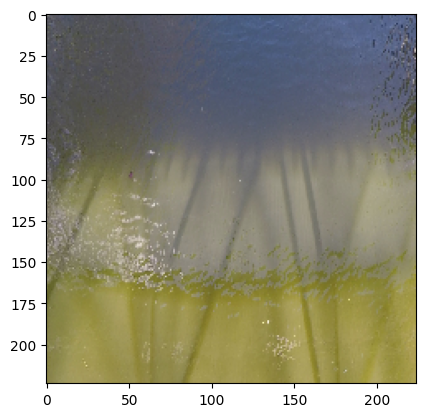

In [5]:
# load test datasets
image = tf.keras.preprocessing.image.load_img(
    path_test, grayscale=False, color_mode="rgb", target_size=(224,224), interpolation="nearest")
plt.imshow(image)
image = tf.keras.preprocessing.image.img_to_array(image) / 255
# print(image)


# image = np.expand_dims(image, axis=0) 


## Load Gradcam method

In [6]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()


In [7]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    # jet = cm.get_cmap("viridis")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_height, image_width))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img


## Model loading

In [8]:
# load MobileNet
model_path = r"F:\Tianlong\PythonProject\deep_plastic\output\TL_vs_scratch\model_trained_for_GradCam\weights\mobile_net_lr_0.0001_TL_all_GC.hdf5"

# load SqueezeNet
# model_path = r"F:\Tianlong\PythonProject\deep_plastic\output\TL_vs_scratch\from_scratch_weights\squeeze_net_lr_0.00001.hdf5"

model = tf.keras.models.load_model(model_path)
# model.summary()


In [9]:
# Predict the one sample in test data
out_put = model.predict(np.expand_dims(image, axis=0))
print ("predicted: ", labels[np.argmax(out_put)])
# print ("True label: ", image[0])


predicted:  No


In [10]:
out_put

array([[6.1228544e-01, 3.8771456e-01, 2.1727134e-10, 5.2600623e-15]],
      dtype=float32)

## Define model layer for gradcam

In [11]:
# MoblieNet
last_conv_layer_name = "Conv_1"
classifier_layer_names = [
    "global_average_pooling2d",
    "dense"
]

# # Squeeze
# last_conv_layer_name = "conv10"
# classifier_layer_names = [
#     "global_average_pooling2d",
#     "dense"
# ]


## Show the heat-map of images

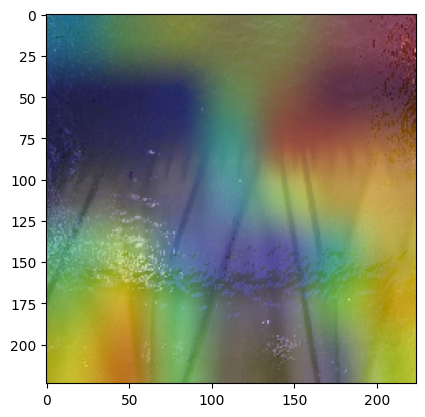

In [12]:
heatmap, top_index = make_gradcam_heatmap(np.expand_dims(
        image, axis=0), model, last_conv_layer_name, classifier_layer_names)
    # print(heatmap.shape)
img = np.uint8(255 * image)
img = superimposed_img(img, heatmap)

plt.imshow(img)